# Project Overview
In this notebook and subsequent notebooks I will attempt to predict mechanically meaningful labels associated with some fan-generated roleplaying game (RPG) content.

I collected post and comment data from Reddit in multiple runs using a command-line tool I wrote for this purpose (see: [PRAW-CoDiaLS](https://github.com/nkuehnle/praw-codials))

The actual text I will be attempting to predict is hosted on one of two websites: [GM Binder](https://gmbinder.com/) or [Homebrewery](https://homebrewery.naturalcrit.com/), which are tools/content hosting providers for fan-made RPG content, primarily Dungeons and Dragons 5th Edition (DnD5e).

The labels make use of the user-assigned "flair" from the subreddit [/r/UnearthedArcana](https://www.reddit.com/r/UnearthedArcana/). UnearthedArcana describes itself as a source of "homebrew" (fan-generated) content and its community rules ensure that every post has a meaningful label ("flair") associated with it. These labels describe the "type" of game content that has been created, be it a character "class" (think achetypal high-fantasy characters knights, wizards, archers, etc) or a "race" (elves, dwarves, humans, etc).

At the start of this document we have only the data about the Reddit submission including the submission flair link to the service described above.

In [1]:
# Utility Imports
import os
from pathlib import Path
# Imports for data processing/handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib as plt
import seaborn as sns

# This Notebook

In this notebook, I'll use the output of manual review of the multi-link comments to further filter and clean the dataset.

In [2]:
# Define a constant (CWD) to use
CWD = Path(os.getcwd())
DATA = CWD / 'data'
PRAW = DATA / 'praw_data'

# Data Imports
There are now two files I'll be working with:
1. CommentsFiltered.csv
2. CommentsDropped.csv
2. MultiLinkCmts.csv

If you are not familiar with Reddit, when users post it can take two forms, "Submissions" and "comments."

Submissions are associated with a specific community or "subreddit" and users can comment on Submissions to discuss them or provide additional commentary.
Submissions can come in multiple forms: link, text, image, etc. The submissions here are only link submissions. Comments are searched for all other types of submissions as users will frequently post an image version of their content and then link to the text copy in the comments on these subreddits. The vast majority of content on /r/UnearthedArcana comes in this second form (an image submission with the link in the comments).

In any case, PRAW-CoDiaLS is written so that they both share the same overall structure, although certain fields are only used for comments (and blank otherwise).

### Shared Fields

| column name | description |
| ----- | ----- |
| link | Raw text URL |
| submission_author | Reddit user who posted the comment |
| submission_id | A unique ID used for locating the submission on Reddit |
| submission_title | The title of the submission on Reddit |
| subreddit | The name of the Subreddit the content was found on (in this case, either UnearthedArcana or DnDHomebrew) |
| submission_flair | the figure number as indicated in the manuscript |
| submission_score | The approximate number of net positive votes received by the submission on Reddit, the actual values are obfuscated by Reddit to avoid manipulation |
| submission_upvote_ratio | The ratio of positive to negative votes |
| submission_date | Date on which the submission was originally made |
| comment_author | Reddit user who posted the comment |
| comment_id | A unique ID used for locating the comment on Reddit |
| comment_score | The approximate number of net positive votes received by the comment on Reddit, the actual values are obfuscated by Reddit to avoid manipulation |
| comment_body | Text of the comment containing markdown elements |
| comment_date | Date on which the comment was originally posted |

### Other Fields

| column name | description |
| ----- | ----- |
| processed | Boolean indicator for whether link has been manually reviewed (MultiLinkCmts.csv only) |
| related_link | Boolean indicator for whether link/text was related to the labeled post (MultiLinkCmts.csv only) |
| discard_reason | Label indicating why the link was discarded (CommentsDiscarded.csv) |

In [3]:
cmts_df = pd.read_csv(PRAW/'CommentsFiltered.csv', index_col='idx').sort_index(axis=0)
cmts_df['manually_reviewed'] = False
discarded_cmts = pd.read_csv(PRAW/'CommentsDropped.csv', index_col='idx').sort_index(axis=0)
multilink_cmts = pd.read_csv(PRAW/'MultiLinkCmts.csv', index_col='idx').sort_index(axis=0)
mismatched_author_cmts = pd.read_csv(PRAW/'AuthorIssues.csv', index_col='idx').sort_index(axis=0)

# Mismatched Authorship Comments

#### Missing/Invalid Content
As before, this includes any links that have either been removed/deleted or otherwise do not really provide useful examples of English 5th edition content (foreign language, styling guides, thought-pieces, etc)

#### Duplication/Redundancy
Other instances of duplication exist within the dataset. These will be handled similarly to how duplicate submissions were handled in the previous notebook (i.e. prioritizing submissions to /r/UnearthedArcana and earlier postings)

In [4]:
mismatched_author_cmts['flair_correct'] = mismatched_author_cmts['submission_flair'] == mismatched_author_cmts['corrected_flair']

In [5]:
null_rows = mismatched_author_cmts['corrected_flair'].isna() & mismatched_author_cmts['manually_reviewed']
null_df = mismatched_author_cmts[null_rows].copy()
null_df['discard_reason'] = "Invalid/Missing Content Type"
mismatched_author_cmts = mismatched_author_cmts[~null_rows]
print(f"Dropped {len(null_df)} links with invalid/missing content.")
discarded_cmts = pd.concat([discarded_cmts, null_df[~null_df.index.isin(discarded_cmts.index)]])

Dropped 8 links with invalid/missing content.


In [6]:
err_rate = ((~mismatched_author_cmts['flair_correct']).sum())/len(mismatched_author_cmts)*100
print(f"{err_rate:.2f}% of remaining comments had incorrect flair")

66.27% of remaining comments had incorrect flair


#### Dropping remaining duplicates

In [7]:
mismatched_author_cmts = mismatched_author_cmts.sort_values(by=["submission_date","comment_date"])
duplicated = mismatched_author_cmts.duplicated(subset=['src_url', 'corrected_flair'], keep='first')
dup_df = mismatched_author_cmts[duplicated].copy()
dup_df['discard_reason'] = "Duplicate Unambiguous Flair"
discarded_cmts = pd.concat([discarded_cmts, dup_df[~dup_df.index.isin(discarded_cmts)]])

In [8]:
mismatches = mismatched_author_cmts.duplicated(subset=["src_url"]).sum() - mismatched_author_cmts.duplicated(subset=["src_url","corrected_flair"]).sum()
if mismatches != 0:
    print(f"There are {mismatches} links with inconsistent flair assignments")
    all_dups = mismatched_author_cmts.duplicated(subset=["src_url"], keep=False).index
    dups_after_correction = mismatched_author_cmts.duplicated(subset=["src_url","corrected_flair"], keep=False).index
    mismatched = [dup for dup in all_dups if dup not in dups_after_correction]
    print(mismatched_author_cmts[mismatched_author_cmts.index.isin(mismatched)])
else:
    print("All duplicated links have consistent flair")

All duplicated links have consistent flair


In [9]:
mismatched_author_cmts = mismatched_author_cmts[~duplicated]
mismatched_author_cmts.sort_index()
print(f"{duplicated.sum()} duplicate links with un-ambiguous submission flair dropped")

31 duplicate links with un-ambiguous submission flair dropped


In [10]:
err_rate = ((~mismatched_author_cmts['flair_correct']).sum())/len(mismatched_author_cmts)*100
print(f"{err_rate:.2f}% of remaining comments had incorrect flair")

64.82% of remaining comments had incorrect flair


### Fixing/re-merging content

In [11]:
null_links = null_df['link'].unique()
null_rows = cmts_df['link'].isin(null_links)
null_df = cmts_df[null_rows].copy()
null_df['submission_flair'] = np.nan
null_df['discard_reason'] = "Invalid/Missing Content Type"
discarded_cmts = pd.concat([discarded_cmts, null_df[~null_df.index.isin(discarded_cmts)]])
cmts_df = cmts_df[~null_rows]
print(f"{null_rows.sum()} links with missing/invalid content types removed from primary comment dataset.")

1 links with missing/invalid content types removed from primary comment dataset.


In [12]:
url_mapper = mismatched_author_cmts.set_index('link')['corrected_flair'].to_dict()

flair_to_correct = cmts_df['link'].isin(url_mapper.keys())
mismatched_author_cmts[mismatched_author_cmts['link'].isin(cmts_df['link'])]
flair_to_correct = flair_to_correct & cmts_df['link'].isin(mismatched_author_cmts['link'])

cmts_df.loc[flair_to_correct, 'submission_flair'] = cmts_df[flair_to_correct]['link'].map(url_mapper).values
cmts_df.loc[flair_to_correct, 'manually_reviewed'] = True

print(f"{flair_to_correct.sum()} entries updated")

26 entries updated


In [13]:
mismatched_author_cmts['submission_flair'] = mismatched_author_cmts['corrected_flair']
mismatched_author_cmts = mismatched_author_cmts.drop(columns=['flair_correct', 'corrected_flair', 'src_url'])
mismatched_author_cmts = mismatched_author_cmts[~mismatched_author_cmts.index.isin(cmts_df.index)]
cmts_df = pd.concat([cmts_df, mismatched_author_cmts[~mismatched_author_cmts.index.isin(cmts_df.index)]])

# Multi-Link Comment Content
Next, I'll re-incorporate the manually-reviewed multi-link comment content.

I'll perform some limited processing to prune bad content and/or duplicates before I merge them back in.

There will be a few angles I'll use for filtering:

#### Missing/Invalid Content
As before, this includes any links that have either been removed/deleted or otherwise do not really provide useful examples of English 5th edition content (foreign language, styling guides, thought-pieces, etc)

#### Content Relation to Parent Submission
Discovered links were flagged as either related or unrelated to the main (parent) submission the comment was made under.

In many cases, these unrelated posts still provided useful content, so they will be kept. However, I'll preferentially keep the ones that were related to the parent submission.

#### Duplication/Redundancy
Other instances of duplication exist within the dataset. These will be handled similarly to how duplicate submissions were handled in the previous notebook (i.e. prioritizing submissions to /r/UnearthedArcana and earlier postings)

In [14]:
multilink_cmts['flair_correct'] = multilink_cmts['submission_flair'] == multilink_cmts['corrected_flair']

<Axes: xlabel='related_link', ylabel='flair_correct'>

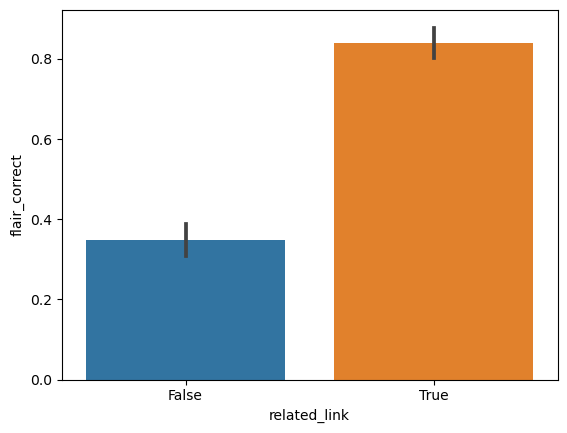

In [15]:
sns.barplot(multilink_cmts, x="related_link", y="flair_correct")

In [16]:
multilink_cmts.groupby('related_link')['flair_correct'].mean()

related_link
False    0.347273
True     0.839378
Name: flair_correct, dtype: float64

<Axes: xlabel='flair_correct', ylabel='related_link'>

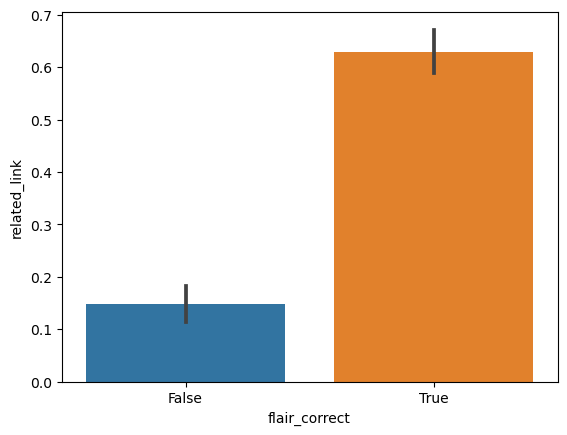

In [17]:
sns.barplot(multilink_cmts, x="flair_correct", y="related_link")

In [18]:
multilink_cmts.groupby('flair_correct')['related_link'].mean()

flair_correct
False    0.147268
True     0.629126
Name: related_link, dtype: float64

In [19]:
reviewed_cmts = multilink_cmts[multilink_cmts['manually_reviewed']]
err_rate = ((~reviewed_cmts['flair_correct']).sum()/len(reviewed_cmts))*100
print(f"{err_rate:.2f}% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post")

44.98% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post


#### Invalid/Missing Content

In [20]:
null_rows = multilink_cmts['corrected_flair'].isna()
null_df = multilink_cmts[null_rows].copy()
null_df['discard_reason'] = "Invalid/Missing Content Type"
discarded_cmts = pd.concat([discarded_cmts, null_df[~null_df.index.isin(discarded_cmts.index)]])
multilink_cmts = multilink_cmts[~null_rows]
print(f"Removed {null_rows.sum()} rows with missing or invalid content.")

Removed 2 rows with missing or invalid content.


In [21]:
reviewed_cmts = multilink_cmts[multilink_cmts['manually_reviewed']]
err_rate = (~reviewed_cmts['flair_correct']).sum()/len(reviewed_cmts)*100
print(f"After filtering, {err_rate:.2f}% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.")

After filtering, 44.86% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.


#### Duplicate Links with Mixed Relationships to the Titular Post

In a few particular cases, a link was duplicated within the dataset and included both posts related to and unrelated to the main submission/flair in question.

I made to sure keep the related instances in these cases. I did not bother to fix the flair given that these will be discarded.

In [22]:
link_mixture = multilink_cmts.groupby('src_url')['related_link'].mean()
multilink_cmts['related_link'] = multilink_cmts['related_link'].astype(bool)
mixed_links = link_mixture[(link_mixture>0) & (link_mixture<1)].index
mixed_links

Index(['https://homebrewery.naturalcrit.com/source/1-M_mgIo6auMreJ7TIIXkIfisYSUnkO1RYoo6GRrq8ZRr',
       'https://homebrewery.naturalcrit.com/source/1-RG_M7OJzm2oMw0cMMXyyzAq3zD1OkJ-Ge_07X_o7ZFE',
       'https://homebrewery.naturalcrit.com/source/1-u6fWltBA4ULSqyO0gzZck9zVI344gFiYwhDrq2dcXSl',
       'https://homebrewery.naturalcrit.com/source/10HyHBXn_Ol0tae9-t5vpZzIGWKPe5l8W6fCTK77Sd8DD',
       'https://homebrewery.naturalcrit.com/source/10WTDFO5SRDmh0x9l8mj-aT_aF0Dce-Kpk_hn68Pftw5j',
       'https://homebrewery.naturalcrit.com/source/10_9qbCu_jDdHfG72oZmLv86sX1F_RKp8g9zTdkduosDo',
       'https://homebrewery.naturalcrit.com/source/11D123fkj2EWNYBvaXuJKGuqydSzJUYBcowQ5pXPpqxKb',
       'https://homebrewery.naturalcrit.com/source/11s4ieAqZiqStfRT3fxFHrHOSLKaUzaifsojvlVDoKawB',
       'https://homebrewery.naturalcrit.com/source/13WCQFSjOhpiJJtx6Oq_oZ-aRw_72O6tz8rPrcDxTSiRb',
       'https://homebrewery.naturalcrit.com/source/13at3aA6Vd-x6A2mxErg-f8GM0VYm4GeqtN96wsMmubR5',
       ...

In [23]:
multilink_cmts[multilink_cmts['src_url'].isin(mixed_links)].sort_values(by="link")

,link,submission_author,submission_id,submission_title,subreddit,corrected_flair,submission_score,submission_upvote_ratio,submission_date,comment_author,comment_id,comment_score,comment_body,comment_date,manually_reviewed,related_link,src_url,submission_flair,flair_correct
idx,,,,,,,,,,,,,,,,,,,
3930,https://gmbinder.com/share/-MSfA82gv8V69JAoqFVq,LaserLlama,ynxm9m,laserllama's Alternate Ranger Class (Update!) ...,UnearthedArcana,Class,601,0.98,NaN,LaserLlama,ivdcakk,2,Glad you enjoy the execution!\n\nAt some point...,NaN,True,False,https://www.gmbinder.com/share/-MSfA82gv8V69JA...,Class,True
1286,https://gmbinder.com/share/-MSfA82gv8V69JAoqFVq,LaserLlama,lyfven,The Alternate Fighter (v1.2.0 Update!) - Becom...,UnearthedArcana,Class,475,0.98,3/5/2021 16:40,LaserLlama,gpsfg1d,19,Hello everyone! Here is the third (public) upd...,3/5/2021 16:41,True,True,https://www.gmbinder.com/share/-MSfA82gv8V69JA...,Class,True
3570,https://gmbinder.com/share/-MW4c30CbGMWLRNgJxgb,LaserLlama,yvb5yt,laserllama's Alternate Ranger: Expanded - A Mu...,UnearthedArcana,Compendium,268,0.98,NaN,LaserLlama,iwdb9t0,7,Hello everyone - today I’m sharing a compendiu...,NaN,True,True,https://www.gmbinder.com/share/-MW4c30CbGMWLRN...,Compendium,True
1223,https://gmbinder.com/share/-MW4c30CbGMWLRNgJxgb,LaserLlama,m54olt,Ranger Archetypes (New & Updated) - Track your...,UnearthedArcana,Compendium,623,0.99,3/14/2021 21:26,LaserLlama,gvg0bt0,1,"No worries, I get them mixed up sometimes too!...",4/22/2021 13:57,True,False,https://www.gmbinder.com/share/-MW4c30CbGMWLRN...,Subclass,False
1914,https://gmbinder.com/share/-MtR2w88UA77uX5gCoB2,StarSailGames,t2drfi,Circle of Geometry: Summon Fractal Creatures a...,UnearthedArcana,Subclass,50,0.93,2/27/2022 2:32,StarSailGames,hylf7pg,3,Hi everyone! Today I'm sharing a quirky druid ...,2/27/2022 2:33,True,False,https://www.gmbinder.com/share/-MtR2w88UA77uX5...,Subclass,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,https://homebrewery.naturalcrit.com/share/1zD4...,Oh_Hi_Mark_,wngw7y,Give me a D&D monster and I'll homebrew you a ...,DnDHomebrew,Monster,149,0.95,NaN,Oh_Hi_Mark_,ik72rt0,1,* [Manticores](https://homebrewery.naturalcrit...,NaN,True,False,https://homebrewery.naturalcrit.com/source/1zD...,5e,False
2423,https://homebrewery.naturalcrit.com/share/1zF0...,Oh_Hi_Mark_,whtmbi,Give me a D&D monster and I'll homebrew you a ...,DnDHomebrew,Monster,185,0.95,1659807006,Oh_Hi_Mark_,ij818f8,3,* [Silver Dragons](https://homebrewery.natural...,1659814781,True,True,https://homebrewery.naturalcrit.com/source/1zF...,Monster,True
3680,https://homebrewery.naturalcrit.com/share/1zF0...,Oh_Hi_Mark_,z092x8,Give me a D&D monster and I'll homebrew you a ...,DnDHomebrew,Monster,26,0.93,NaN,Oh_Hi_Mark_,ix5tk1y,2,Chromatics\n\n* [Black Dragons](https://homebr...,NaN,True,False,https://homebrewery.naturalcrit.com/source/1zF...,5e,False


In [24]:
inds_to_drop = (multilink_cmts['src_url'].isin(mixed_links)) & (~multilink_cmts['related_link'])
unrelated_dups = multilink_cmts[inds_to_drop].copy()
unrelated_dups['discard_reason'] = "Unrelated duplicate link"
discarded_cmts = pd.concat([discarded_cmts, unrelated_dups[~unrelated_dups.index.isin(discarded_cmts.index)]])
multilink_cmts = multilink_cmts[~inds_to_drop]
print(f"{inds_to_drop.sum()} duplicates dropped in favor of a comment associated with a relevant parent post.")

142 duplicates dropped in favor of a comment associated with a relevant parent post.


In [25]:
reviewed_cmts = multilink_cmts[multilink_cmts['manually_reviewed']]
err_rate = (~reviewed_cmts['flair_correct']).sum()/len(reviewed_cmts)*100
print(f"After filtering, {err_rate:.2f}% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.")

After filtering, 35.23% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.


#### Dropping remaining duplicates

In [26]:
multilink_cmts = multilink_cmts.sort_values(by=["submission_date","comment_date"])
duplicated = multilink_cmts.duplicated(subset=['src_url', 'corrected_flair'], keep='first')
dup_df = multilink_cmts[duplicated].copy()
dup_df['discard_reason'] = "Duplicate Unambiguous Flair"
discarded_cmts = pd.concat([discarded_cmts, dup_df[~dup_df.index.isin(discarded_cmts.index)]])

In [27]:
mismatches = multilink_cmts.duplicated(subset=["src_url"]).sum() - multilink_cmts.duplicated(subset=["src_url","corrected_flair"]).sum()
if mismatches != 0:
    print(f"There are {mismatches} links with inconsistent flair assignments")
    all_dups = multilink_cmts.duplicated(subset=["src_url"], keep=False).index
    dups_after_correction = multilink_cmts.duplicated(subset=["src_url","corrected_flair"], keep=False).index
    mismatched = [dup for dup in all_dups if dup not in dups_after_correction]
    print(multilink_cmts[multilink_cmts.index.isin(mismatched)])
else:
    print("All duplicated links have consistent flair")

All duplicated links have consistent flair


In [28]:
multilink_cmts = multilink_cmts[~duplicated]
multilink_cmts.sort_index()
print(f"{duplicated.sum()} duplicate links with un-ambiguous submission flair dropped")

15 duplicate links with un-ambiguous submission flair dropped


In [29]:
reviewed_cmts = multilink_cmts[multilink_cmts['manually_reviewed']]
err_rate = (~reviewed_cmts['flair_correct']).sum()/len(reviewed_cmts)*100
print(f"After filtering, {err_rate:.2f}% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.")

After filtering, 35.01% of manually reviewed links from multi-link comments differed from the submission flair associated with their parent post.


### Fixing/re-merging content

In [30]:
null_links = null_df['link'].unique()
null_rows = cmts_df['link'].isin(null_links)
null_df = cmts_df[null_rows].copy()
null_df['submission_flair'] = np.nan
null_df['discard_reason'] = "Invalid/Missing Content Type"
discarded_cmts = pd.concat([discarded_cmts, null_df[~null_df.index.isin(discarded_cmts.index)]])
cmts_df = cmts_df[~null_rows]
print(f"{null_rows.sum()} links with missing/invalid content types removed from primary comment dataset.")

0 links with missing/invalid content types removed from primary comment dataset.


In [31]:
url_mapper = multilink_cmts.set_index('link')['corrected_flair'].to_dict()
flair_to_correct = cmts_df['link'].isin(url_mapper.keys())
flair_to_correct = flair_to_correct & cmts_df['link'].isin(multilink_cmts['link'])

In [32]:
cmts_df.loc[flair_to_correct, 'submission_flair'] = cmts_df[flair_to_correct]['link'].map(url_mapper).values
cmts_df.loc[flair_to_correct, 'manually_reviewed'] = True
print(f"{flair_to_correct.sum()} entries updated")

30 entries updated


In [33]:
multilink_cmts['submission_flair'] = multilink_cmts['corrected_flair']
multilink_cmts = multilink_cmts.drop(columns=['flair_correct', 'corrected_flair', 'src_url'])
cmts_df = pd.concat([cmts_df,multilink_cmts[~multilink_cmts.index.isin(cmts_df.index)]])

### Part 2 -- Duplications: Content updates/versioning

Now that we've re-incorporated all of the content we've revieed so far, we'll further filter down the dataset.

Some content gets re-posted occasionally with updates. These often aren't materially different and they can skew our perception of how the resulting model performs in the real world. i.e. if we use an earlier verion of a document for training then attempt to predict a slightly modified/updated version during testing, we'll over-estimate performance

The earlier processing by date will have removed some instances of this, but only in select cases. Here I'll keep the oldest instance of each link for which the flair is the same. This should fix most cases of versioning, while also fixing a few other issues surrounding re-posted content.

In [34]:
cmt_dups = cmts_df.sort_values(by=["manually_reviewed",'subreddit','submission_date','related_link'], axis=0, ascending=[False,False,True,False])
cmt_dups = cmt_dups[cmt_dups.duplicated(subset=['link','submission_flair'], keep='first')]
cmt_dups['discard_reason'] = 'Duplicate Unambiguous Flair'
discarded_cmts = pd.concat([discarded_cmts, cmt_dups])
print(f"{len(cmt_dups)} duplicate links with un-ambiguous submission flair dropped")
cmts_df = cmts_df[~cmts_df.index.isin(cmt_dups.index)]

91 duplicate links with un-ambiguous submission flair dropped


### Part 3 -- Remaining duplicates

I'll manually sort out any remaining issues in the code blocks below.

In [35]:
remaining_dups = cmts_df.duplicated(subset='link', keep=False)
cmts_df[remaining_dups].sort_values(by=['link','manually_reviewed'], ascending=False)

,link,submission_author,submission_id,submission_title,subreddit,submission_flair,submission_score,submission_upvote_ratio,submission_date,comment_author,comment_id,comment_score,comment_body,comment_date,manually_reviewed,related_link
idx,,,,,,,,,,,,,,,,
2189,https://gmbinder.com/share/-Mt-8R9tQYhuLrhMR5-L,Sensitive_Coyote_865,sp43pv,Conjure insect - A druid cantrip,UnearthedArcana,Spell,783,0.98,1644491044.0,Sensitive_Coyote_865,hwcq3c5,66,"I don't know about you, but I love semi-useles...",1644491171.0,False,NaN
2899,https://gmbinder.com/share/-Mt-8R9tQYhuLrhMR5-L,Sensitive_Coyote_865,wo8xq3,Circle of Vermin - final-ish version,UnearthedArcana,Subclass,241,0.99,1660490698.0,Sensitive_Coyote_865,ik9gy7p,6,Here is the final (more or less) version of my...,1660490783.0,False,NaN


In [36]:
to_remove = cmts_df.duplicated(subset='link', keep='last')
# This appears to have been updated since the original posting
manual_removal = cmts_df[to_remove].copy()
manual_removal ['discard_reason'] = 'Manually removed mislabeled'
cmts_df = cmts_df[~to_remove]
discarded_cmts = pd.concat([discarded_cmts, manual_removal])

In [37]:
discarded_cmts['discard_reason'].value_counts()

UA crosspost                    302
Simple duplicate                235
Has UA primary submission       215
Newer multi-comment             181
Unrelated duplicate link        142
Duplicate Unambiguous Flair     137
Missing path                     33
Invalid/Missing Content Type     18
Manually removed mislabeled       1
Name: discard_reason, dtype: int64

In [38]:
discarded_cmts.to_csv(PRAW/'FinalCommentsDropped.csv', index_label='idx')
cmts_df.to_csv(PRAW/'FinalCommentsFiltered.csv', index_label='idx')